# Класифікація обʼєктів новобудови за текстовим описом за допомогою зворотної нейронної мережі

Рекурсивна нейронна мережа використовується для наборів даних які представляють собою серію послідовних даних. Наприклад, опис обʼєкту нерухомості є текстовою строкою. Кожний символ повʼязаний із попередніми символами та із наступними. Через це використання звичайної нейронної мережі є неможливим при роботі із текстом.

Натомість, для цього використовуються Рекурсивні Нейронні Мережі.

https://www.youtube.com/watch?v=VtRLrQ3Ev-U&ab_channel=freeCodeCamp.org

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
from keras.models import Sequential
from keras.layers import Dense, Dropout, TextVectorization, Embedding, LSTM
from keras.optimizers import Adam
from keras.utils import to_categorical
# BinaryCrossentropy функція повинна використовуватися для задач бінарної класифікації. Для мультикласової класифікації потрібно використовувати CategoricalCrossentropy
# from keras.losses import BinaryCrossentropy
from keras.losses import CategoricalCrossentropy
from sklearn.model_selection import train_test_split

2023-05-12 11:52:45.347687: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Завантаження набору даних

### Ознайомлення з набором даних

In [3]:
df = pd.read_csv('./real-estate-mapped.csv')

### Збереження набору даних для подальшого використання при розробці нового набору даних

In [4]:
df_initial = df.copy();

In [5]:
df.head()

,residence,developer,description,address,district,class,ceilingHeight,numApartmentsTotal,year,pricePerSquareMeter,price,area,rooms,floor,minutesToCityCenter,assess,crimeRateInDistrict
0,А136 Highlight Tower,DIM,Residential complex A136 Highlight Tower is a ...,"вул. Антоновича, 136-138",Голосіївський р-н,бізнес,3,324,2023.0,137800.0,7441200.0,54,1,18.0,48,52536,2317
1,А136 Highlight Tower,DIM,Residential complex A136 Highlight Tower is a ...,"вул. Антоновича, 136-138",Голосіївський р-н,бізнес,3,324,2023.0,137800.0,7992400.0,58,1,NaN,48,52536,2317
2,А136 Highlight Tower,DIM,Residential complex A136 Highlight Tower is a ...,"вул. Антоновича, 136-138",Голосіївський р-н,бізнес,3,324,2023.0,125275.0,10022000.0,80,2,7.0,48,52536,2317
3,А136 Highlight Tower,DIM,Residential complex A136 Highlight Tower is a ...,"вул. Антоновича, 136-138",Голосіївський р-н,бізнес,3,324,2023.0,125275.0,10147275.0,81,2,13.0,48,52536,2317
4,А136 Highlight Tower,DIM,Residential complex A136 Highlight Tower is a ...,"вул. Антоновича, 136-138",Голосіївський р-н,бізнес,3,324,2023.0,125275.0,10648375.0,85,2,17.0,48,52536,2317


In [6]:
df.sample()

,residence,developer,description,address,district,class,ceilingHeight,numApartmentsTotal,year,pricePerSquareMeter,price,area,rooms,floor,minutesToCityCenter,assess,crimeRateInDistrict
92,ЖК Greenville на Печерську,Greenville,Greenville is a combination of residential spa...,"пров. Новопечерський, 5",Печерський р-н,бізнес,3,800,2023.5,73925.0,5396525.0,73,2,11.5,46,136750,2537


In [7]:
df.shape

(169, 17)

### Фільтрація пустих значень

In [8]:
df = df.dropna()

In [9]:
df.shape

(152, 17)

### Доступні в наборі даних класи нерухомості

In [10]:
df['class'].unique()

array(['бізнес', 'комфорт', 'преміум'], dtype=object)

In [11]:
df.head()

,residence,developer,description,address,district,class,ceilingHeight,numApartmentsTotal,year,pricePerSquareMeter,price,area,rooms,floor,minutesToCityCenter,assess,crimeRateInDistrict
0,А136 Highlight Tower,DIM,Residential complex A136 Highlight Tower is a ...,"вул. Антоновича, 136-138",Голосіївський р-н,бізнес,3,324,2023.0,137800.0,7441200.0,54,1,18.0,48,52536,2317
2,А136 Highlight Tower,DIM,Residential complex A136 Highlight Tower is a ...,"вул. Антоновича, 136-138",Голосіївський р-н,бізнес,3,324,2023.0,125275.0,10022000.0,80,2,7.0,48,52536,2317
3,А136 Highlight Tower,DIM,Residential complex A136 Highlight Tower is a ...,"вул. Антоновича, 136-138",Голосіївський р-н,бізнес,3,324,2023.0,125275.0,10147275.0,81,2,13.0,48,52536,2317
4,А136 Highlight Tower,DIM,Residential complex A136 Highlight Tower is a ...,"вул. Антоновича, 136-138",Голосіївський р-н,бізнес,3,324,2023.0,125275.0,10648375.0,85,2,17.0,48,52536,2317
5,А136 Highlight Tower,DIM,Residential complex A136 Highlight Tower is a ...,"вул. Антоновича, 136-138",Голосіївський р-н,бізнес,3,324,2023.0,125275.0,11024200.0,88,2,14.2,48,52536,2317


### Переведення класів нерухомості до числових значень

In [12]:
class_to_num_map = { 'бізнес': 0, 'преміум': 1, 'комфорт': 2, 'економ': 3 }

df['class'] = df['class'].map(class_to_num_map)

In [13]:
df = df[['description', 'class']]

In [14]:
df.head()

,description,class
0,Residential complex A136 Highlight Tower is a ...,0
2,Residential complex A136 Highlight Tower is a ...,0
3,Residential complex A136 Highlight Tower is a ...,0
4,Residential complex A136 Highlight Tower is a ...,0
5,Residential complex A136 Highlight Tower is a ...,0


## Підготовка даних для тренування моделі

### Створення сету характеристик і міток

TODO: використання imblearn.oversampling -> RandomOverSampler для прирівнювання к-сті зразків певного класу

In [15]:
train, val, test = np.split(df.sample(frac=1), [int(0.8 * len(df)), int(0.9 * len(df))])

In [16]:
train.shape, val.shape, test.shape

((121, 2), (15, 2), (16, 2))

In [17]:
df.head()

,description,class
0,Residential complex A136 Highlight Tower is a ...,0
2,Residential complex A136 Highlight Tower is a ...,0
3,Residential complex A136 Highlight Tower is a ...,0
4,Residential complex A136 Highlight Tower is a ...,0
5,Residential complex A136 Highlight Tower is a ...,0


### Переведення міток до категоріальних значень

Так як мітки в даному випадку варіюються від 1 до 4 що вказує на певний клас будівлі, для того щоб повʼязати ці числа із виходом із softmax вихідного шару нейронної мережі, потрібно перевести числа до категоріального виду використовуюючи допоміжні функції keras.

In [18]:
x_train = train['description'].values
y_train = to_categorical(train['class'], 4)

x_valid = val['description'].values
y_valid = to_categorical(val['class'], 4)

x_test = test['description'].values
y_test = to_categorical(test['class'], 4)

x_pred = ['The residential complex "Rusanivska Gavan is part of the development of a new microdistrict: new residential complexes with their own shopping infrastructure, two kindergartens and a school will be built on the site of an abandoned industrial zone. Only two houses belong to ""Rusanivska Havana"" - one on the first line and one more on the second. Combined, both buildings will be a common residential area, where there will be underground parking, and on its roof - a closed courtyard without cars. The main idea of ​​the ""Rusanivska Gavan"" complex is the advantages of living near the water: views of the Dnipro and Trukhanov Island, as well as an equipped embankment along the shore. Infrastructure You can reach the city train station in 10 minutes from the complex, and after the completion of the construction of the Podilsk bridge crossing and the Podilsk-Vygurivska subway line, it will be even more convenient to get to the right bank. There are supermarkets of large retail chains nearby: 15 minutes on foot to Novus and "" Silpo"", 10 minutes by car to Varus, another Novus and another ""Silpo"". You can also reach the Left Bank market in 5 minutes, where fresh fruits and vegetables are sold. As part of the development of the new neighborhood, 2 kindergartens and 1 school will be built, which will make it easier for young families to find a preschool. If suddenly there are not enough places or something doesnt work out, there are other kindergartens in the area nearby: 15 minutes on foot to 566, 8 minutes by car to Kraina Dytynstva, 10 minutes by car to kindergartens #337, #261 and #444. For older children, schools #72, #65, #128 and Ukrainian College named after V.O. Sukhomlynskyi. To train nearby, you will need to walk for 15-20 minutes or drive 5-7 minutes to the fitness clubs ""Sport Land"", the Iron fitness club, the Grand Sport and ""Atletico-fitness"" clubs. 7 minutes by car - and you are in A hydropark, where you can sunbathe on the beach, take a walk in the fresh air, ride a bike, sit in a cafe or take your child to attractions. Features include its own boiler room for each house, an equipped embankment on the banks of the Dnipro — a place for walks, morning jogs and relaxing on sunbeds, a sports area with exercise machines sky, childrens play areas for children of all ages']

### Композиція моделі

In [19]:
embedding = 'https://tfhub.dev/google/nnlm-en-dim50/2'
hub_layer = hub.KerasLayer(embedding, dtype=tf.string, trainable=True)

2023-05-12 11:52:55.417871: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [20]:
model = Sequential()

model.add(hub_layer)
model.add(Dense(16, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(4, activation='softmax'))

In [21]:
model.compile(optimizer=Adam(learning_rate=0.001), loss=CategoricalCrossentropy(), metrics=['accuracy'])

In [22]:
model.evaluate(x_train, y_train)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


4/4 [==============================] - 1s 4ms/step - loss: 1.4700 - accuracy: 0.1653


[1.469961166381836, 0.1652892529964447]

### Тренування моделі

Попередньо модель була натренована на 10-20 епохах, але цього було недостатньо. Після 10-20 епох точність моделі все ще зростає і модель не переходить в режим Overfitting

In [23]:
history = model.fit(x=x_train, y=y_train, epochs=30, validation_data=(x_valid, y_valid))

Epoch 1/30
4/4 [==============================] - 4s 818ms/step - loss: 1.3826 - accuracy: 0.2231 - val_loss: 1.4366 - val_accuracy: 0.1333
Epoch 2/30
4/4 [==============================] - 3s 670ms/step - loss: 1.2047 - accuracy: 0.4132 - val_loss: 1.2980 - val_accuracy: 0.4000
Epoch 3/30
4/4 [==============================] - 3s 670ms/step - loss: 1.0835 - accuracy: 0.7025 - val_loss: 1.1979 - val_accuracy: 0.4667
Epoch 4/30
4/4 [==============================] - 3s 674ms/step - loss: 0.9869 - accuracy: 0.7273 - val_loss: 1.1000 - val_accuracy: 0.4667
Epoch 5/30
4/4 [==============================] - 3s 674ms/step - loss: 0.8874 - accuracy: 0.7851 - val_loss: 0.9997 - val_accuracy: 0.6667
Epoch 6/30
4/4 [==============================] - 3s 676ms/step - loss: 0.7757 - accuracy: 0.8264 - val_loss: 0.8858 - val_accuracy: 0.9333
Epoch 7/30
4/4 [==============================] - 3s 713ms/step - loss: 0.6643 - accuracy: 0.9752 - val_loss: 0.7732 - val_accuracy: 1.0000
Epoch 8/30
4/4 [====

### Результати тренування моделі

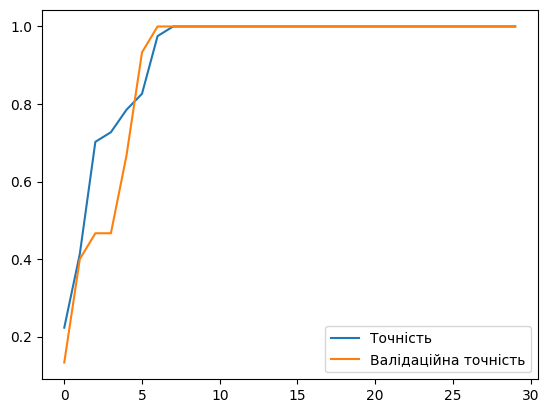

In [24]:
plt.plot(history.history['accuracy'], label="Точність")
plt.plot(history.history['val_accuracy'], label="Валідаційна точність")
plt.legend()

plt.show()

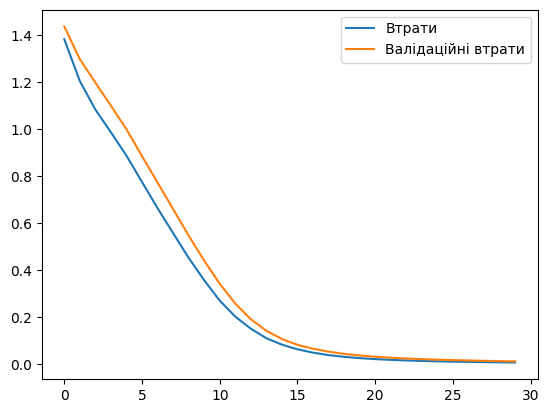

In [25]:
plt.plot(history.history['loss'], label="Втрати")
plt.plot(history.history['val_loss'], label="Валідаційні втрати")
plt.legend()

plt.show()

## Перевірка моделі на тестових даних яких раніше модель не бачила

In [26]:
def pred_to_text(pred):
    return list(class_to_num_map.keys())[list(class_to_num_map.values()).index(pred)]

In [27]:
pred_to_text(0), pred_to_text(1), pred_to_text(2), pred_to_text(3)

('бізнес', 'преміум', 'комфорт', 'економ')

In [28]:
model.evaluate(x_test, y_test)

1/1 [==============================] - 0s 184ms/step - loss: 0.0063 - accuracy: 1.0000


[0.006282740738242865, 1.0]

In [29]:
pred = model.predict(x_pred)
pred_index = np.argmax(pred)

pred_to_text(pred_index)

1/1 [==============================] - 0s 262ms/step


'комфорт'

TODO: створити новий набір даних із результатами роботи нейронної мережі і передати його на вхід до алгоритму лінійної регресії для оцінки вартості нерухомості

## Експорт моделі

In [30]:
# model.save('class_evaluation_model')

INFO:tensorflow:Assets written to: class_evaluation_model/assets


INFO:tensorflow:Assets written to: class_evaluation_model/assets


## Генерація нового набору даних із результатами роботи нейронної мережі

In [31]:
predicted = model.predict(df_initial['description'].values)
predicted

6/6 [==============================] - 0s 2ms/step


array([[9.88778532e-01, 7.81076727e-03, 1.48418429e-03, 1.92645949e-03],
       [9.88778532e-01, 7.81076727e-03, 1.48418429e-03, 1.92645949e-03],
       [9.88778532e-01, 7.81076727e-03, 1.48418429e-03, 1.92645949e-03],
       [9.88778532e-01, 7.81076727e-03, 1.48418429e-03, 1.92645949e-03],
       [9.88778532e-01, 7.81076727e-03, 1.48418429e-03, 1.92645949e-03],
       [9.88778532e-01, 7.81076727e-03, 1.48418429e-03, 1.92645949e-03],
       [9.88778532e-01, 7.81076727e-03, 1.48418429e-03, 1.92645949e-03],
       [9.88778532e-01, 7.81076727e-03, 1.48418429e-03, 1.92645949e-03],
       [9.88778532e-01, 7.81076727e-03, 1.48418429e-03, 1.92645949e-03],
       [9.88778532e-01, 7.81076727e-03, 1.48418429e-03, 1.92645949e-03],
       [8.73060635e-05, 3.28270975e-03, 9.93664503e-01, 2.96549452e-03],
       [8.73060635e-05, 3.28270975e-03, 9.93664503e-01, 2.96549452e-03],
       [8.73060635e-05, 3.28270975e-03, 9.93664503e-01, 2.96549452e-03],
       [8.73060635e-05, 3.28270975e-03, 9.93664503e

In [32]:
predicted_to_human_readable = list(map(lambda categorical: pred_to_text(np.argmax(categorical)), predicted))
predicted_to_human_readable

['бізнес',
 'бізнес',
 'бізнес',
 'бізнес',
 'бізнес',
 'бізнес',
 'бізнес',
 'бізнес',
 'бізнес',
 'бізнес',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'комфорт',
 'бізнес',
 'б

In [33]:
crafted_dataset = df_initial.copy()

In [34]:
crafted_dataset.shape, len(predicted_to_human_readable)

((169, 17), 169)

In [35]:
crafted_dataset['predictedClass'] = predicted_to_human_readable

In [36]:
crafted_dataset

,residence,developer,description,address,district,class,ceilingHeight,numApartmentsTotal,year,pricePerSquareMeter,price,area,rooms,floor,minutesToCityCenter,assess,crimeRateInDistrict,predictedClass
0,А136 Highlight Tower,DIM,Residential complex A136 Highlight Tower is a ...,"вул. Антоновича, 136-138",Голосіївський р-н,бізнес,3,324,2023.0,137800.0,7441200.0,54,1,18.0,48,52536,2317,бізнес
1,А136 Highlight Tower,DIM,Residential complex A136 Highlight Tower is a ...,"вул. Антоновича, 136-138",Голосіївський р-н,бізнес,3,324,2023.0,137800.0,7992400.0,58,1,NaN,48,52536,2317,бізнес
2,А136 Highlight Tower,DIM,Residential complex A136 Highlight Tower is a ...,"вул. Антоновича, 136-138",Голосіївський р-н,бізнес,3,324,2023.0,125275.0,10022000.0,80,2,7.0,48,52536,2317,бізнес
3,А136 Highlight Tower,DIM,Residential complex A136 Highlight Tower is a ...,"вул. Антоновича, 136-138",Голосіївський р-н,бізнес,3,324,2023.0,125275.0,10147275.0,81,2,13.0,48,52536,2317,бізнес
4,А136 Highlight Tower,DIM,Residential complex A136 Highlight Tower is a ...,"вул. Антоновича, 136-138",Голосіївський р-н,бізнес,3,324,2023.0,125275.0,10648375.0,85,2,17.0,48,52536,2317,бізнес
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164,ЖК 4 сезони,УМК,The 4 Seasons residential complex in Kyiv is a...,"вул. Михайла Максимовича (Трутенка), 3г",Голосіївський р-н,комфорт,2,2060,2024.0,NaN,NaN,97,3,25.0,109,52536,2317,комфорт
165,ЖК 4 сезони,УМК,The 4 Seasons residential complex in Kyiv is a...,"вул. Михайла Максимовича (Трутенка), 3г",Голосіївський р-н,комфорт,2,2060,2024.0,NaN,NaN,106,3,25.0,109,52536,2317,комфорт
166,ЖК 4 сезони,УМК,The 4 Seasons residential complex in Kyiv is a...,"вул. Михайла Максимовича (Трутенка), 3г",Голосіївський р-н,комфорт,2,2060,2024.0,NaN,NaN,117,3,25.0,109,52536,2317,комфорт
167,ЖК 4 сезони,УМК,The 4 Seasons residential complex in Kyiv is a...,"вул. Михайла Максимовича (Трутенка), 3г",Голосіївський р-н,комфорт,2,2060,2024.0,NaN,NaN,134,3,25.0,109,52536,2317,комфорт


In [37]:
crafted_dataset = crafted_dataset.drop(['class'], axis=1)
crafted_dataset.to_csv('real-estate-with-nn-results.csv', encoding='utf-8')